# **Stranger Sections Challenge**

## TL;DR

**Eager to get working?** This challenge involves unsupervised segmentation of thin section images. There are 1000 unlabeled images in the dataset your job will be to provide a model that can accurately segment the blobs on the thin sections. You are free to explore any and all methods you see fit to effectively segment these images. There are two types of thin section images, plain light and ultraviolet light images. Ultaviolet light images are used to identify brown blobs that fluoresce a yellow or green color. Each image may contain a variety of blobs to segment. We have provided three examples of satisfactory labels in the `Data` discussion below to serve as a guide. Challenger's work will be evaluated by a panel of judges for accuracy of the label masks (70%), effeciency of the code (25%), and notebook organization/interprability (5%). In addition to the best overall model, challengers will be able to win prizes for honorable mentions.

## Background

Scale is one of the more interesting aspects of science.  Biology investigates genomes and entire ecosystems.  Physics spans quantum forces to gravitational waves from the Big Bang.  Understanding all the different scales for a problem helps us better understand our natural world and how it is changing.  For this challenge, we're asking you to investigate the micrometer scale of geosciences by examining thin sections of rocks and identifying their components.

This challenge aims to build a machine-learning solution to a problem often encountered by machine learning researchers; label scarcity. Challengers will recieve 1000 unlabeled thin section images, and will need to provide a model that is able to correctly segment all blobs on each image.

The fun of this challenge is that there is no one correct way to complete this task. Challengers should focus on their strengths to build a model. If you are an expert with unsupervised clustering, maybe you use `sklearn`'s `kmeans` to create segments with clustering. Maybe you want to test out Meta's SAM model, or better yet one of the offshoots like `segmenteverygrain`. Maybe your background is image processing and you spend most of your time building a pipeline to ingest and enhance the images prior to segmentation.

Since this challenge gives you the freedom to explore different paths, we will be awarding several different prizes for different accomplishments. A total prize pool of $25,000 dollars will be awarded. See `Prizes` section for more information about prize distributions. Whatever approach you choose, all we ask that the solution involves machine learning.

## Data

As highlighted above, the dataset consists of 1000 unlabeled thin section images. Some of these images will will be plain light images and others will be UV light. There will be various blobs on on each thin section image that need to be segmented. Below are 3 examples showing how one might segment the images. The examples show the three types of blobs found on the images. As you'll see, there are potentially more segments on the image than what is currently provided. 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import time

%matplotlib inline

### Example 1

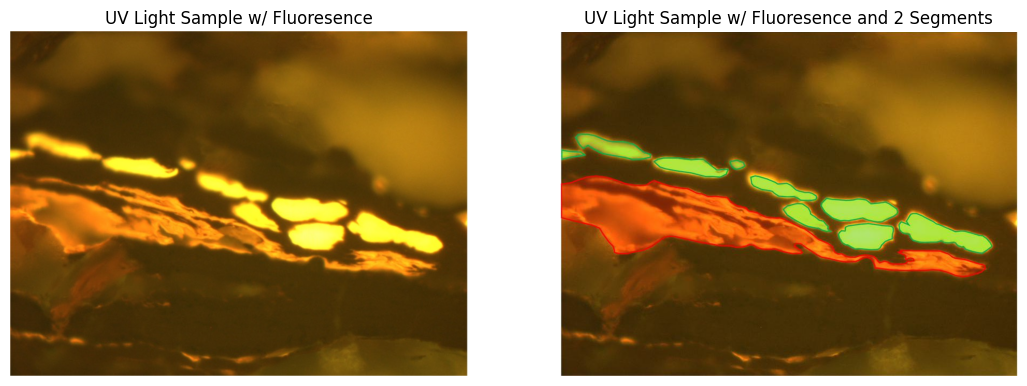

In [4]:
# figure size in inches optional
rcParams['figure.figsize'] = 13 ,10

# read images
img_A = mpimg.imread('images/image1.jpg')
img_B = mpimg.imread('images/image1_label.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('UV Light Sample w/ Fluoresence')
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].title.set_text('UV Light Sample w/ Fluoresence and 2 Segments')
ax[1].imshow(img_B)
ax[1].axis('off')
plt.savefig('sample1.png')
plt.show()

### Example 2

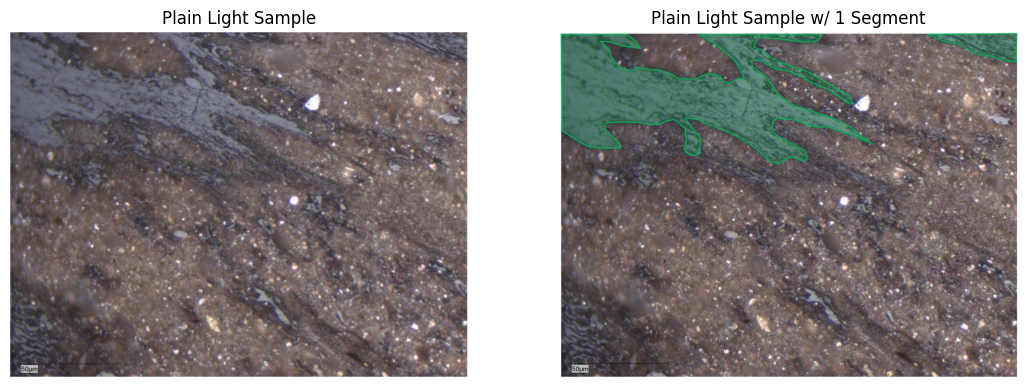

In [5]:
# figure size in inches optional
rcParams['figure.figsize'] = 13 ,10

# read images
img_A = mpimg.imread('images/image2.jpg')
img_B = mpimg.imread('images/image2_label.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('Plain Light Sample')
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].title.set_text('Plain Light Sample w/ 1 Segment')
ax[1].imshow(img_B)
ax[1].axis('off')
plt.savefig('sample2.png')
plt.show()

### Example 3

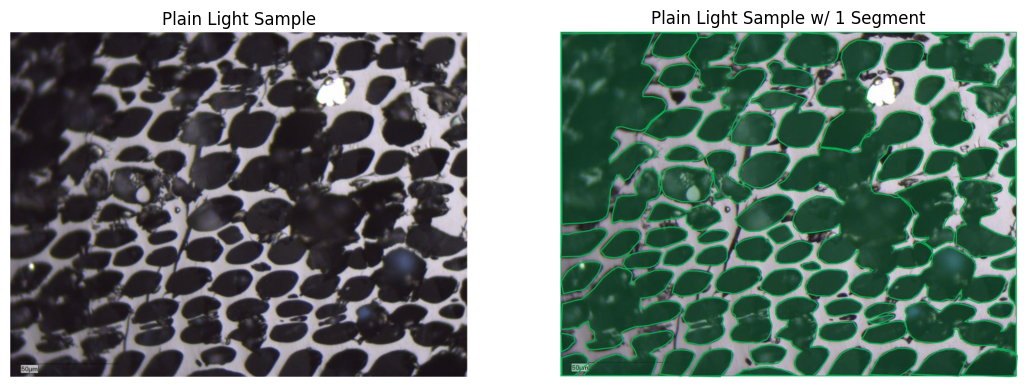

In [6]:
# figure size in inches optional
rcParams['figure.figsize'] = 13 ,10

# read images
img_A = mpimg.imread('images/image3.jpg')
img_B = mpimg.imread('images/image3_label.jpg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('Plain Light Sample')
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].title.set_text('Plain Light Sample w/ 1 Segment')
ax[1].imshow(img_B)
ax[1].axis('off')
plt.savefig('sample3.png')
plt.show()

## Evaluation

Can you build a model to accurately segment all blobs in a thin section image? This is an unstructured competition where your task is to create a Notebook that best addresses the Evaluation criteria below. Submissions should be submitted on the Stranger Sections challenge page and will be judged by Xeek based on how well they address:

* **Image Segments (70%)**
    * How well are the images segmented? 
    * If there are multiple blobs are they broken out into different segments? 
    * Is the entire blob segmented? 
    * If there are metrics available, did the author provide a way of assessing the performance and accuracy of their solution? - Silhouette Score, ARI, Loss Function
* **Code efficiency (25%)**
    * What is the model runtime? *Note: If a clear winner cannot be determined visually, judges will look at code performance to determine a winner.*
* **Notebook Presentation (5%)**
    * Does the notebook contain data visualizations that help to communicate the author’s main points? 
    * Is the code documented in a way that makes it easy to understand and reproduce? 
    * Were all external sources of data made public and cited appropriately?

## Code

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from skimage.measure import regionprops, regionprops_table
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tqdm import trange
import urllib.request
%matplotlib qt

### Download model checkpoint

In [44]:
import urllib.request
urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth', 'sam_vit_h_4b8939.pth')

('sam_vit_h_4b8939.pth', <http.client.HTTPMessage at 0x1c013fdc990>)

### Load models

In [ ]:
# %%time

model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('./checkpoints/seg_model');

sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")

In [139]:
import torch

if torch.cuda.is_available():
    sam.to(device='gpu')
else:
    sam.to(device='cpu')

### Run segmentation

In [299]:
# reload(seg)

fname = 'images/ara-train/enhanced/yk73ji_enhanced.jpg'
# fname = 'adapteq_0smyr1.jpg'

big_im = np.array(load_img(fname))
big_im_pred = seg.predict_big_image(big_im, model, I=256)

labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=10.0)
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels, min_area=50.0)

100%|██████████| 148/148 [00:19<00:00,  7.47it/s]
148it [03:42,  1.50s/it]
100%|██████████| 2/2 [00:00<00:00, 38.77it/s]


### QC distribution of SAM prompts

In [79]:
plt.figure()
plt.imshow(big_im_pred)
plt.scatter(coords[:,0], coords[:,1], c='k');

### Delete or merge grains in segmentation result
* click on the grain to remove and press 'x' key
* click on two grains to merge, and press the 'm'm key

In [300]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', 
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event', 
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run below cell once finished with editing

In [301]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

Update the 'all_grains' list after deleting and merging grains

In [302]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

0it [00:00, ?it/s]


Plot the updated set of grains:

In [303]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(big_im)
plt.xticks([])
plt.yticks([])
seg.plot_image_w_colorful_grains(big_im, all_grains, ax, cmap='Paired')
# seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)
plt.xlim([0, np.shape(big_im)[1]])
plt.ylim([np.shape(big_im)[0], 0]);

## Add new grains
* click on unsegmented grain that you want to add
* press the 'x' key to delete the last grain added
* press the 'm' key to merge the last 2 grains added
* right click outside the grain (but inside mask) to restrict the grain to a smaller mask

In [304]:
predictor = SamPredictor(sam)
predictor.set_image(big_im) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, big_im, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

In [305]:
fig.canvas.mpl_disconnect(cid3)
fig.canvas.mpl_disconnect(cid4)

After finished deleting / adding grain masks, run below cell to generate updated set of grains:

In [306]:
all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, big_im)

100%|██████████| 76/76 [00:00<00:00, 205.37it/s]


### Save mask and grain labels to PNG files

In [307]:
dirname = 'images/output/'
# write grayscale mask to PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_mask.png', mask_all)
# Define a colormap using matplotlib
num_classes = len(all_grains)
cmap = plt.get_cmap('viridis', num_classes)
# Map each class label to a unique color using the colormap
vis_mask = cmap(labels.astype(np.uint16))[:,:,:3] * 255
vis_mask = vis_mask.astype(np.uint8)
# Save the mask as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_labels.png', vis_mask)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_image.png', cv2.cvtColor(big_im, cv2.COLOR_BGR2RGB))

True

In [74]:
print(dirname + fname.split('/')[-1][:-4] + '_mask.png')

images/output/0dpocx_mask.png


## Image Adjustment

In [180]:
import cv2
img = cv2.imread('images/ara-train/0pe3b9.jpg')
cols, rows, chan = img.shape
brightness = np.sum(img) / (255 * cols * rows)

cv2.imshow("Input", img)

In [131]:
minimum_brightness = 0.80

ratio = brightness / minimum_brightness
if ratio >= 1:
    print("Image already bright enough")
    # return img
    cv2.imshow("Output - no change", img)

# Otherwise, adjust brightness to get the target brightness
# return cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)
img2 = cv2.convertScaleAbs(img, alpha = 1 / ratio, beta = 0)
cv2.imshow("Output - Scaled", img2)

Image already bright enough


## Alternative Function for Auto Brightness & Contrast

In [24]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

image = cv2.imread('images/ara-train/0smyr1.jpg')
auto_result, alpha, beta = automatic_brightness_and_contrast(image)
print('alpha', alpha)
print('beta', beta)
cv2.imshow('auto_result', auto_result)
cv2.imwrite('auto_result.png', auto_result)
cv2.imshow('image', image)
cv2.waitKey()

C:\Users\Jeffrey.Roth.NMES\AppData\Local\Temp\ipykernel_8284\3786057561.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accumulator.append(float(hist[0]))
C:\Users\Jeffrey.Roth.NMES\AppData\Local\Temp\ipykernel_8284\3786057561.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accumulator.append(accumulator[index -1] + float(hist[index]))


alpha 3.8059701492537314
beta -274.02985074626866


-1

## Alternative method using Pillow

In [167]:
from PIL import Image, ImageEnhance

file = 'images/ara-train/1c9f5w.jpg'
img = Image.open(file)
img.show()

In [168]:
filter = ImageEnhance.Brightness(img)
new_image = filter.enhance(0.5)

new_image.show()

In [161]:
filter = ImageEnhance.Contrast(img)
new_image = filter.enhance(4)
img.show()

In [165]:
filter = ImageEnhance.Sharpness(img)
new_image = filter.enhance(8)
img.show()

## Another alternative method

In [28]:
def enhance_contrast_and_brightness(image_path, target_contrast=1.0, target_brightness=0.0):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization to enhance contrast
    equalized_image = cv2.equalizeHist(gray_image)

    # Calculate the current contrast and brightness
    mean_brightness = np.mean(equalized_image)
    std_dev = np.std(equalized_image)

    # Calculate the necessary scaling factors to adjust contrast and brightness
    contrast_scale = target_contrast * (std_dev / 128.0)
    brightness_adjustment = target_brightness - mean_brightness * contrast_scale

    # Apply contrast and brightness adjustments
    adjusted_image = cv2.convertScaleAbs(equalized_image, alpha=contrast_scale, beta=brightness_adjustment)

    # Convert back to color image
    adjusted_color_image = cv2.cvtColor(adjusted_image, cv2.COLOR_GRAY2BGR)

    # Save the enhanced image
    # cv2.imwrite(output_path, adjusted_color_image)
    return(adjusted_color_image)

image_path = 'images/ara-train/0smyr1.jpg'
image = cv2.imread(image_path)
auto_result = enhance_contrast_and_brightness(image_path)
# print('alpha', alpha)
# print('beta', beta)
cv2.imshow('auto_result', auto_result)
cv2.imwrite('auto_result.png', auto_result)
cv2.imshow('image', image)
cv2.waitKey()

-1

## Yet another method (scikit-learn adaptive equalization)

In [69]:
from skimage import exposure
import cv2

path = 'images/ara-train/'
fname = '0c3n69.jpg'
img_path = path + fname

img = cv2.imread(img_path)

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.01)

# Display Results
cv2.imshow('input', img)
# cv2.imshow('Contrast Stretching', img_rescale)
# cv2.imshow('Equalization', img_eq)
cv2.imshow('Adaptive Equalization', img_adapteq)

fname_output = 'adapteq_' + fname
cv2.imwrite(fname_output, 255*img_adapteq)
cv2.waitKey()

c:\Users\Jeffrey.Roth.NMES\projects\stranger-sections\.venv\Lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


-1

## Process all images with adaptive equalization

In [99]:
from skimage import exposure
import cv2
from glob import glob

def perform_adaptive_equalization(img_path, clip_lim=0.01):
    img = cv2.imread(img_path)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=clip_lim)

    return(img_adapteq)

image_dir = 'images/ara-train/'
output_dir = image_dir + 'enhanced/'
images = glob(image_dir + "*.JPG")

for image in images:
    output = perform_adaptive_equalization(image)
    img_name = image.split("\\")[1].split(".")[0] + '_enhanced' + '.jpg'
    cv2.imwrite(output_dir + img_name, 255*output)